# Make Supplemental Figure 3: Summary Statistics

This notebook plots the summary statistics for all proteins with data for six of eight cancers. Summary statistics include:
* the average differential expression and standard deviation of the differential expressions
* the average p-value and standard deviation of the p-values

We also identify MMS19 as one of the more consistent genes. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest
import matplotlib.ticker as ticker

import cptac
import cptac.utils as u

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Returns the number of significant tests (num of cancers with sig tests for a certain gene)
def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05: # Using corrected p-values from FDR-bh
            numSig += 1
            
    return numSig

In [3]:
# Returns true if either consisitently pos or neg differential expressions are found for the protein in the row

def Consistent(row):
    hasPos = False
    hasNeg= False
    for item in row: 
        if pd.isnull(item):
            continue
        if item < 0:
            hasNeg = True
        if item > 0:
            hasPos = True
           
    if hasPos & (hasNeg == False): # All pos
        return True
    elif (hasPos == False) & hasNeg: # All neg
        return True
    return False


# Step 1: Calculate Std Dev and Mean

Get df with the FDR-bh corrected p-values for all trans genes. Next, calculate the total number of p-values significant for each trans protein across the 8 cancers. Calculate the summary statistics: 
* mean of p-values and standard deviation
* mean of differential expressions and standard deviation 
    * (differential expression = median of trans protein abundance in tumors with deleted PTEN - median of of trans protein abundance in tumors with wildtype PTEN)

In [4]:
df_fdr_pvals = pd.read_csv("../Make_Tables/csv/all_proteins.csv")
df_fdr_pvals = df_fdr_pvals.loc[df_fdr_pvals['Proteomics'] != 'PTEN'] # Drop PTEN

In [5]:
# Use Pvalue_sig to add a column with the count of sig tests for each gene across the cancers
df_fdr_pvals["Num_sig"] = df_fdr_pvals.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value", "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].apply(Pvalue_sig, axis = 1)
df_fdr_pvals = df_fdr_pvals.sort_values(by=['Num_sig'],ascending=False)

In [6]:
# Calculate mean and standard deviation for p-values 
df_fdr_pvals["Mean_P_Value"] = df_fdr_pvals.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value", "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].mean(axis = 1)
df_fdr_pvals["Std_Dev_P_Value"] = df_fdr_pvals.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value", "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].std(axis = 1)

# Calculate mean and standard deviation for differential expressions
df_fdr_pvals["Mean_Dif_Expression"] = (df_fdr_pvals.loc[:,["Gbm_Median","Hnscc_Median","Luad_Median","Lscc_Median", "Brca_Median","Ov_Median","En_Median","Colon_Median"]].mean(axis = 1))
df_fdr_pvals["Std_Dev_Dif_Expression"] = (df_fdr_pvals.loc[:,["Gbm_Median","Hnscc_Median","Luad_Median","Lscc_Median", "Brca_Median","Ov_Median","En_Median","Colon_Median"]].std(axis = 1))

In [7]:
# Keep trans genes that are significant in at least 1 cancer
df_fdr_pvals_1 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([1,2,3,4,5,6,7,8])]
print('Total genes sig in at least 1 cancer:', len(df_fdr_pvals_1.Proteomics.unique()))

Total genes sig in at least 1 cancer: 2630


In [8]:
# Only include genes that have data for at least 6/8 genes.
df_fdr_pvals_1 = df_fdr_pvals_1.dropna(thresh=12, axis=0)
total_genes_6_cancers = len(df_fdr_pvals_1.Proteomics.unique())
print('Genes sig in at least 1 cancer (data for 6/8 cancers):', total_genes_6_cancers)

Genes sig in at least 1 cancer (data for 6/8 cancers): 2493


# Step 2: Make Figure

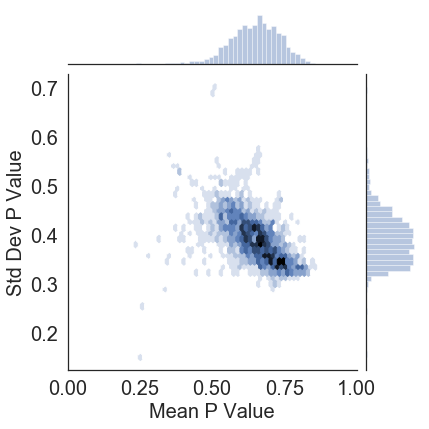

In [17]:
sns.set(rc={'xtick.labelsize':20,'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_Value","Std_Dev_P_Value",data = df_fdr_pvals_1, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))
g.ax_marg_x.set_xlim(0, 1)
plt.show()
g.savefig("Supplementary_PTEN_3_pval.png", dpi = 300)

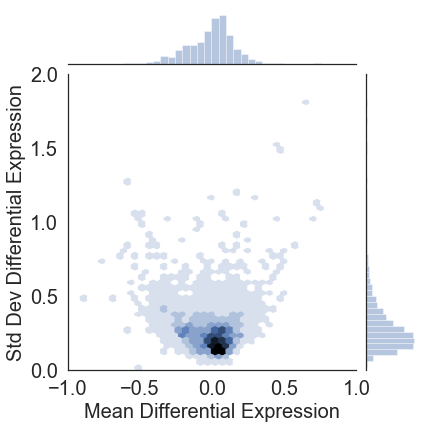

In [16]:
sns.set(rc={'xtick.labelsize':20, 'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_Dif_Expression","Std_Dev_Dif_Expression",data = df_fdr_pvals_1, kind="hex", bins = 10)
        .set_axis_labels("Mean Differential Expression", "Std Dev Differential Expression", fontsize=20))

g.ax_marg_x.set_xlim(-1, 1)
g.ax_marg_y.set_ylim(0, 2)

g.savefig("Supplementary_PTEN_3_dif_expression.png", dpi = 300)
plt.show()

# Find range of 90% of the differential expression summary statistics

The manuscript mentions a range of the mean differential expression and its standard deviation for most of the genes (90%). 

In [11]:
mean_de = df_fdr_pvals_1['Mean_Dif_Expression']
low_percentile = 5
high_percentile = 95

low = np.nanpercentile(mean_de, low_percentile, interpolation = 'nearest')
high = np.nanpercentile(mean_de, high_percentile, interpolation = 'nearest')
print('Distribution of the Average Differential Expressions:\n', '\nmin:', mean_de.min(),
      '\n'+str(low_percentile)+' percentile:', low, '\n'+str(high_percentile)+' percentile:',
      high,'\nmax:', mean_de.max())  
      

Distribution of the Average Differential Expressions:
 
min: -1.1642387218580257 
5 percentile: -0.31242051582684727 
95 percentile: 0.2203914845799846 
max: 1.3569247140801983


In [12]:
std_de = df_fdr_pvals_1['Std_Dev_Dif_Expression']
low_percentile = 5
high_percentile = 95

low_sd = np.nanpercentile(std_de, low_percentile, interpolation = 'nearest')
high_sd = np.nanpercentile(std_de, high_percentile, interpolation = 'nearest')
print('Distribution of the Std Dev of Differential Expressions:\n', '\nmin:', std_de.min(), 
      '\n'+str(low_percentile)+' percentile:', low_sd, '\n'+str(high_percentile)+' percentile:',
      high_sd,'\nmax:', std_de.max()) 

Distribution of the Std Dev of Differential Expressions:
 
min: 0.021015153734880526 
5 percentile: 0.11868729301336012 
95 percentile: 0.5901825912526282 
max: 2.024376211360896


# Identify one of the most consistent genes

First, we filter for genes with the most significant tests (3). Next we find genes with a consistent decrease or increase in their proteomic abundance when PTEN is deleted (consistent differential expression).

In [13]:
df_fdr_pvals_3 = df_fdr_pvals_1[df_fdr_pvals_1['Num_sig'].isin([3])] # 3 is the highest number of sig tests for a gene

# Create column with true if differential expression is either all pos or all neg
df_fdr_pvals_3['consistent'] = (df_fdr_pvals_3.loc[:,["Gbm_Median","Hnscc_Median","Luad_Median","Lscc_Median", "Brca_Median","Ov_Median","En_Median","Colon_Median"]]).apply(Consistent, axis = 1)
consistent_sig_3 = df_fdr_pvals_3[df_fdr_pvals_3['consistent'] == True]

total_num_sig_3 = len(df_fdr_pvals_3)
num_sig_3_consistent = len(consistent_sig_3)
print('Number of genes with a consistent differential expression (sig in 3 cancers):', num_sig_3_consistent, '\nPercentage:',
      num_sig_3_consistent, '/', total_num_sig_3, '* 100 = ', (num_sig_3_consistent/total_num_sig_3) * 100)

consistent_sig_3.iloc[:,:18:2]

Number of genes with a consistent differential expression (sig in 3 cancers): 3 
Percentage: 3 / 38 * 100 =  7.894736842105263


,Proteomics,Gbm_Median,Hnscc_Median,Luad_Median,Lscc_Median,Brca_Median,Ov_Median,En_Median,Colon_Median
420,ATAD1,-0.414812,-0.182747,-0.50905,-1.34185,-0.06935,-0.218273,-0.14574,-0.16475
417,CHUK,-0.242224,-0.224067,-0.57880,-0.43600,-0.36610,-0.222607,-0.10430,-0.01335
66,MMS19,-0.324287,-0.123084,-0.62000,-0.35665,-0.65340,-0.324897,-0.08470,-0.12180


We reference MMS19 in the manuscript as one of the most consistent genes because it has one of the consistently lowest differential expressions and one of the smallest standard deviations of the differential expression. It is also the only significant gene in Ovarian (also significant in Gbm and Luad).

In [14]:
gene = 'MMS19' 
gene_df = df_fdr_pvals.loc[df_fdr_pvals['Proteomics'] == gene]
sd_stats = gene_df[['Proteomics','Mean_Dif_Expression', 'Std_Dev_Dif_Expression']]
print(sd_stats)
mms19 = gene_df.iloc[:,::2]
mms19

   Proteomics  Mean_Dif_Expression  Std_Dev_Dif_Expression
66      MMS19            -0.326102                0.218981


,Proteomics,Gbm_Median,Hnscc_Median,Luad_Median,Lscc_Median,Brca_Median,Ov_Median,En_Median,Colon_Median,Mean_P_Value,Mean_Dif_Expression
66,MMS19,-0.324287,-0.123084,-0.62,-0.35665,-0.6534,-0.324897,-0.0847,-0.1218,0.260827,-0.326102


In [15]:
# Check consistent genes in sig at least 1
df_fdr_pvals_consistent = df_fdr_pvals_1[df_fdr_pvals_1['Num_sig'].isin([1,2,3])]

df_fdr_pvals_consistent['consistent'] = (df_fdr_pvals_consistent.loc[:,["Gbm_Median","Hnscc_Median","Luad_Median","Lscc_Median", "Brca_Median","Ov_Median","En_Median","Colon_Median"]]).apply(Consistent, axis = 1)
consistent = df_fdr_pvals_consistent[df_fdr_pvals_consistent['consistent'] == True]

num_consistent_1 = len(consistent)
print('Number of genes with a consistent differential expression (sig > 1):', num_consistent_1, '\n\nPercentage:', 
     num_consistent_1,'/',total_genes_6_cancers, '* 100 = ', str((num_consistent_1/total_genes_6_cancers)*100)[:4])


Number of genes with a consistent differential expression (sig > 1): 80 

Percentage: 80 / 2493 * 100 =  3.20
